Взять CIFAR100 и обучить resnet18 с нуля на нем

Определить легкие и тяжелые объекты по лоссам итоговой модели

Взять другую модель и обучить её для CIFAR100  двумя способами:

1)объекты в рандомном порядке n эпох

2)чем больше номер эпохи чем больше вероятность выбрать сложный объект 

(да,распределение на индексах:вероятность выбрать объект сначала тем меньше,тем он сложнее,по ходу обучения распределение выходит на равномерное)

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

from tqdm import tqdm

In [ ]:
set_seed(42)

In [ ]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

In [ ]:
def get_loaders(data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
losses_train_history = {'random':[],'hard first':[],'easy first':[]}
losses_val_history = {'random':[],'hard first':[],'easy first':[]}

1)Random

In [ ]:
from torchvision.models import resnet18

model = resnet18(weights='DEFAULT')
model.fc = nn.Linear(512,100)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


In [ ]:
train_loader,test_loader = get_loaders()

100%|██████████| 169001437/169001437 [00:13<00:00, 12671596.00it/s]


Extracting cifar-100/cifar-100-python.tar.gz to cifar-100
Files already downloaded and verified


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [ ]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break

x = x.to(device)
output = model(x)
print(output.shape)

y = y.to(device)
loss = loss_function(output,y)
loss

torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.Size([32, 100])


tensor(5.1852, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
n_epochs = 10

for i in range(n_epochs):
  model.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')
  losses_train_history['random'].append(train_loss / train_len)
  losses_val_history['random'].append(val_loss / val_len)

100%|██████████| 313/313 [00:03<00:00, 79.70it/s]


epoch 0: train loss:2.7289886474609375 val loss:2.0758867263793945


100%|██████████| 313/313 [00:04<00:00, 74.21it/s]


epoch 1: train loss:2.047841787338257 val loss:1.8787962198257446


100%|██████████| 313/313 [00:04<00:00, 67.11it/s]


epoch 2: train loss:1.7684392929077148 val loss:1.7797573804855347


100%|██████████| 313/313 [00:04<00:00, 68.27it/s]


epoch 3: train loss:1.5884369611740112 val loss:1.750663161277771


100%|██████████| 313/313 [00:04<00:00, 69.63it/s]


epoch 4: train loss:1.4379208087921143 val loss:1.671268105506897


100%|██████████| 313/313 [00:04<00:00, 71.61it/s]


epoch 5: train loss:1.3061949014663696 val loss:1.6756365299224854


100%|██████████| 313/313 [00:04<00:00, 70.94it/s]


epoch 6: train loss:1.1917494535446167 val loss:1.7040494680404663


100%|██████████| 313/313 [00:04<00:00, 65.03it/s]


epoch 7: train loss:1.097192406654358 val loss:1.7097994089126587


100%|██████████| 313/313 [00:04<00:00, 63.34it/s]


epoch 8: train loss:1.0019954442977905 val loss:1.6802847385406494


100%|██████████| 313/313 [00:05<00:00, 61.88it/s]

epoch 9: train loss:0.9261168241500854 val loss:1.7140905857086182


In [ ]:
val_acc = 0
model.eval()
for x,y in train_loader:
  x,y = x.to(device), y.to(device)
  logits = model(x)
  preds = logits.max(1)[1]
  val_acc += (y == preds).sum()

val_acc / len(train_loader) / 32

tensor(0.8218, device='cuda:0')

In [ ]:
loss_function = nn.CrossEntropyLoss(reduction='none')
losses = []
with torch.no_grad():
  for x,y in train_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    batch_loss = loss_function(logits,y)
    losses.append(batch_loss)

loss_per_object = torch.hstack(losses)
loss_per_object.shape

torch.Size([50000])

In [ ]:
def get_loaders_weighted(weights,data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
 
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, sampler = sampler,
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)
    
    return train_loader, test_loader

2)hard first

In [ ]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [ ]:
n_epochs = 10

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**(-1.1)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['hard first'].append(train_loss / train_len)
  losses_val_history['hard first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 68.67it/s]


epoch 0: train loss:2.5360043048858643 val loss:2.174665689468384
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 61.91it/s]


epoch 1: train loss:1.813902497291565 val loss:1.9134985208511353
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 77.83it/s]


epoch 2: train loss:1.5318273305892944 val loss:1.8694124221801758
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 80.79it/s]


epoch 3: train loss:1.3730857372283936 val loss:1.8739416599273682
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 67.69it/s]


epoch 4: train loss:1.2139579057693481 val loss:1.8344720602035522
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 62.53it/s]


epoch 5: train loss:1.0988256931304932 val loss:1.8406562805175781
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 79.27it/s]


epoch 6: train loss:1.0182569026947021 val loss:1.820266604423523
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 78.01it/s]


epoch 7: train loss:0.9232044816017151 val loss:1.8146196603775024
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 78.36it/s]


epoch 8: train loss:0.8525692820549011 val loss:1.8857421875
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 64.03it/s]

epoch 9: train loss:0.7961569428443909 val loss:1.8688554763793945


3)easy first

In [ ]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [ ]:
n_epochs = 10

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**1.1
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['easy first'].append(train_loss / train_len)
  losses_val_history['easy first'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 60.45it/s]


epoch 0: train loss:2.5788118839263916 val loss:2.19295072555542
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 76.76it/s]


epoch 1: train loss:1.9035000801086426 val loss:1.976481556892395
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 77.48it/s]


epoch 2: train loss:1.6307892799377441 val loss:1.8856523036956787
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 72.99it/s]


epoch 3: train loss:1.4386341571807861 val loss:1.8373383283615112
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 62.65it/s]


epoch 4: train loss:1.2992610931396484 val loss:1.804947018623352
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 76.05it/s]


epoch 5: train loss:1.1787199974060059 val loss:1.7570252418518066
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 76.39it/s]


epoch 6: train loss:1.0669564008712769 val loss:1.8484995365142822
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:03<00:00, 78.61it/s]


epoch 7: train loss:0.9741820096969604 val loss:1.8340859413146973
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 72.35it/s]


epoch 8: train loss:0.9080197215080261 val loss:1.8053607940673828
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 59.65it/s]

epoch 9: train loss:0.8264814615249634 val loss:1.8346693515777588


In [ ]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

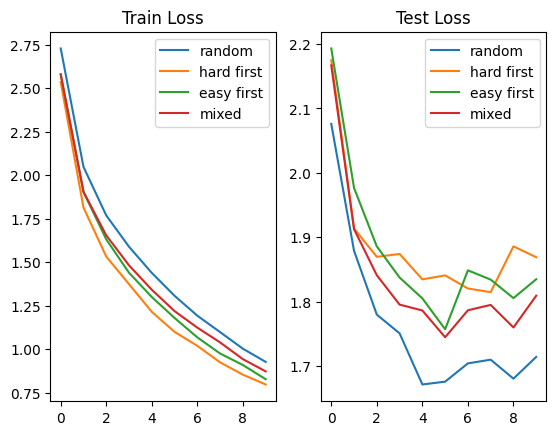

In [34]:
fig,axes = plt.subplots(1,2)
for key,value in losses_train_history.items():
  axes[0].plot(range(n_epochs),tensor_list_to_list(value),label=str(key))
axes[0].set_title('Train Loss')
for key,value in losses_val_history.items():
  axes[1].plot(range(n_epochs),tensor_list_to_list(value),label=str(key))
axes[1].set_title('Test Loss')
axes[0].legend()
axes[1].legend()

In [32]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,100)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=3e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [31]:
losses_train_history['mixed'] = []
losses_val_history['mixed'] = []

In [33]:
n_epochs = 10

for i in range(n_epochs):
  weights = 1. / (loss_per_object + 1.0)**((n_epochs//2 - i) / 6)
  train_loader,test_loader = get_loaders_weighted(weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      preds = model_transfer(x)
      loss = loss_function(preds,y)
      val_loss += loss    
  
  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')

  losses_train_history['mixed'].append(train_loss / train_len)
  losses_val_history['mixed'].append(val_loss / val_len)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 70.90it/s]


epoch 0: train loss:2.580512523651123 val loss:2.166724920272827
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 62.70it/s]


epoch 1: train loss:1.9046213626861572 val loss:1.9124890565872192
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 63.30it/s]


epoch 2: train loss:1.6538904905319214 val loss:1.840902328491211
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 67.93it/s]


epoch 3: train loss:1.4812695980072021 val loss:1.7952808141708374
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 57.64it/s]


epoch 4: train loss:1.3409483432769775 val loss:1.7861859798431396
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 67.78it/s]


epoch 5: train loss:1.2180532217025757 val loss:1.7446311712265015
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 56.12it/s]


epoch 6: train loss:1.1230076551437378 val loss:1.7864594459533691
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 68.90it/s]


epoch 7: train loss:1.0379644632339478 val loss:1.7948089838027954
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:05<00:00, 56.08it/s]


epoch 8: train loss:0.9418758749961853 val loss:1.7597914934158325
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 313/313 [00:04<00:00, 68.47it/s]

epoch 9: train loss:0.8715276718139648 val loss:1.809114933013916
